### Seasonal cycle of polar SAT for sensitivity runs

In [18]:
import numpy as np
import platform as platform
import cccmaplots as cplt
import cccmautils as cutl
import cccmaNC as cnc
import constants as con
%matplotlib inline


model = 'CanAM4'
bp=con.get_basepath()
basepath=bp['basepath'] + model + '/'; subdir=bp['subdir']

field='st'
ccasename='kemctl1' # control
pcases = ('kem1pert1b','kem1pert2','kem1pert3')

coldt = {'kem1pert1b': 'blue',
        'kem1pert2': 'red',
        'kem1pert3': 'cyan'}

#'kem1pert1b' # no adjusted SST, w/ adjusted thickness
#'kem1pert2' # adjusted SST and thickness
# 'kem1pert3' # adjusted SST, but no adjusted thickness

cfname = basepath + ccasename + subdir + ccasename + '_' + field + '_001-121_ts.nc'
cfld = cnc.getNCvar(cfname,field.upper(),timesel='002-01-01,121-12-31')

lat = cnc.getNCvar(cfname,'lat')
lon = cnc.getNCvar(cfname,'lon')

flddt={}; fldregdt={}
for pcase in (ccasename,)+pcases:
    
    fname = basepath + pcase + subdir + pcase + '_' + field + '_001-121_ts.nc'
    fld = cnc.getNCvar(fname,field.upper(),timesel='002-01-01,121-12-31')
    flddt[pcase],_ = cutl.climatologize(fld)
    fldregdt[pcase] = cutl.polar_mean_areawgted3d(flddt[pcase],lat,lon,latlim=70,model=None)


(12, 64, 129)


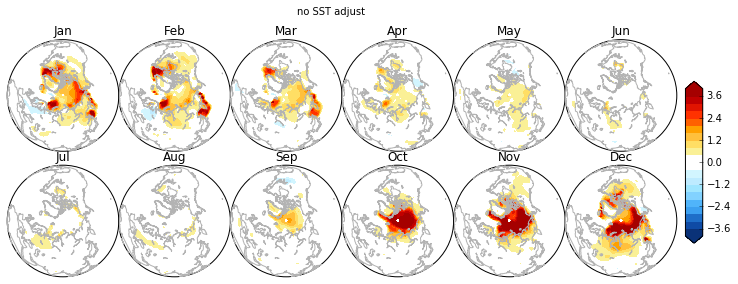

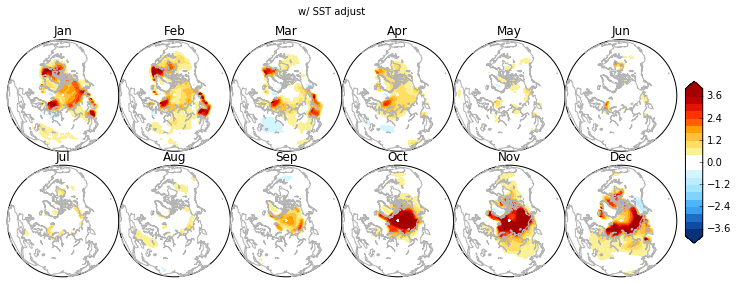

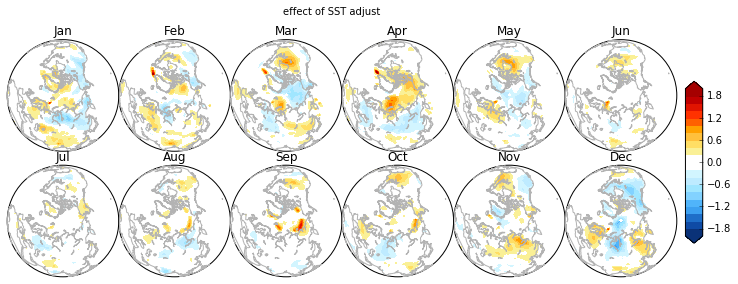

In [14]:
print flddt['kemctl1'].shape

plt.figure()
ret = cplt.map_allmonths(flddt['kem1pert1b']-flddt['kemctl1'],lat,lon,ptype='nheur',
                      cmin=-4,cmax=4,title='no SST adjust')

plt.figure()
ret = cplt.map_allmonths(flddt['kem1pert2']-flddt['kemctl1'],lat,lon,ptype='nheur',
                      cmin=-4,cmax=4,title='w/ SST adjust')


plt.figure()
ret = cplt.map_allmonths(flddt['kem1pert2']-flddt['kem1pert1b'],lat,lon,ptype='nheur',
                      cmin=-2,cmax=2,title='effect of SST adjust')


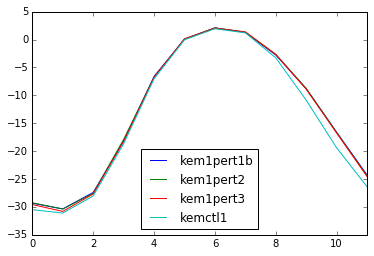

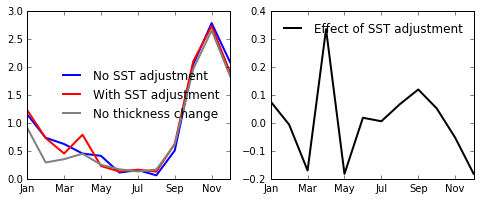

In [31]:
import pandas as pd

coldt = {'kem1pert1b': 'blue',
        'kem1pert2': 'red',
        'kem1pert3': '0.5'}


flddf = pd.DataFrame(fldregdt)
flddf.plot()

fig,axs = plt.subplots(1,2,figsize=(8,3))
ax=axs[0]
for pcase in pcases:
    
    ax.plot(fldregdt[pcase] - fldregdt['kemctl1'],linewidth=2,color=coldt[pcase])

ax.set_xticklabels(con.get_mon()[::2])
ax.set_xlim(0,11)
ax.legend(('No SST adjustment','With SST adjustment','No thickness change'),
          loc='best',frameon=False)

ax=axs[1]
ax.plot(fldregdt['kem1pert2'] - fldregdt['kem1pert1b'],linewidth=2,color='k')
ax.set_xticklabels(con.get_mon()[::2])
ax.set_xlim(0,11)
ax.legend(('Effect of SST adjustment',),
          loc='best',frameon=False)


### Now get the ensemble of diff BCs

In [44]:
import loadmodeldata as lmd
cutl=reload(cutl)

sims=('R1','R2','R3','R4','R5')
#sims=('E1','E2','E3','E4','E5')

field='tas'

simconv1=1
if field=='tas': simfield1='st'; simncfield1='ST'
elif field=='zg50000.00': simfield1='gz50000'; simncfield1='PHI'; simconv1=1/con.get_g()
elif field=='sia': simfield1='sicn'; simncfield1='SICN'; print '@@ danger, sia actually sicn average'
elif field=='sic': simfield1='sicn'; simncfield1='SICN'; simconv1=100
else: print 'cannot addsims for ' + field;

enscdf = lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), timefreq='climo', 
                      filetype='ctl')#*simconv1

enspdf = lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), timefreq='climo', 
                      filetype='pert')#*simconv1

enscregdt={}; enspregdt={}
for sim in sims:
    
    enscregdt[sim] = cutl.polar_mean_areawgted3d(enscdf[sim],lat,lon,latlim=70,model=None)
    enspregdt[sim] = cutl.polar_mean_areawgted3d(enspdf[sim],lat,lon,latlim=70,model=None)
    

@@ probably should invert the order such that it is field, season, sim?
climo
st ST
R1
/HOME/rkm/work/DATA/CanAM4/kemctl1r1/ts/kemctl1r1_st_001-121_ts.nc
R2
/HOME/rkm/work/DATA/CanAM4/kemctl1r2/ts/kemctl1r2_st_001-121_ts.nc
R3
/HOME/rkm/work/DATA/CanAM4/kemctl1r3/ts/kemctl1r3_st_001-121_ts.nc
R4
/HOME/rkm/work/DATA/CanAM4/kemctl1r4/ts/kemctl1r4_st_001-121_ts.nc
R5
/HOME/rkm/work/DATA/CanAM4/kemctl1r5/ts/kemctl1r5_st_001-121_ts.nc
@@ probably should invert the order such that it is field, season, sim?
climo
st ST
R1
/HOME/rkm/work/DATA/CanAM4/kemctl1r1/ts/kemctl1r1_st_001-121_ts.nc
R2
/HOME/rkm/work/DATA/CanAM4/kemctl1r2/ts/kemctl1r2_st_001-121_ts.nc
R3
/HOME/rkm/work/DATA/CanAM4/kemctl1r3/ts/kemctl1r3_st_001-121_ts.nc
R4
/HOME/rkm/work/DATA/CanAM4/kemctl1r4/ts/kemctl1r4_st_001-121_ts.nc
R5
/HOME/rkm/work/DATA/CanAM4/kemctl1r5/ts/kemctl1r5_st_001-121_ts.nc


(5, 12)


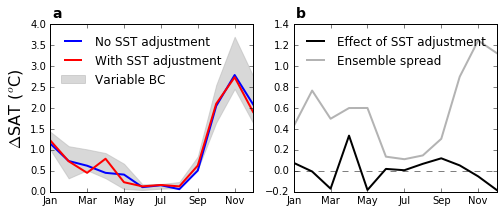

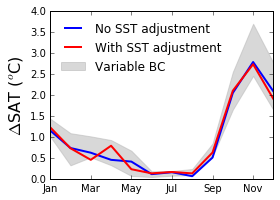

In [70]:
printtofile=True

fsz=16

ensspread = np.array(enspregdt.values()) - np.array(enscregdt.values())
print ensspread.shape
ensdiffmean = ensspread.mean(axis=0)



fig,axs = plt.subplots(1,2,figsize=(8,3))
ax=axs[0]
for pcase in pcases[:2]:
    
    ax.plot(fldregdt[pcase] - fldregdt['kemctl1'],linewidth=2,color=coldt[pcase])
#ax.plot(ensdiffmean,linewidth=2,color='0.5')

#for sim in sims:
    
#    ax.plot(enspregdt[sim] - enscregdt[sim],linewidth=1,color='0.7')
ax.fill_between(np.arange(0,12),ensspread.min(axis=0),ensspread.max(axis=0),
               color='0.7',alpha=0.5)

ax.set_ylabel('$\Delta$SAT ($^o$C)',fontsize=fsz)
ax.set_xticklabels(con.get_mon()[::2])
ax.set_xlim(0,11)
#ax.legend(('No SST adjustment','With SST adjustment','Variable BC mean','Variable BC'),
#          loc='best',frameon=False)
ax.legend(('No SST adjustment','With SST adjustment','Variable BC'),
          loc='best',frameon=False)
ax.annotate('a',xy=(0.01,1.04),xycoords='axes fraction',fontsize=14,fontweight='bold')

ax=axs[1]
ax.plot(fldregdt['kem1pert2'] - fldregdt['kem1pert1b'],linewidth=2,color='k')
ax.plot(ensspread.max(axis=0)-ensspread.min(axis=0),linewidth=2,color='0.7')
ax.axhline(y=0,color='k',linestyle='dashed',linewidth=.5)
ax.set_xticklabels(con.get_mon()[::2])
ax.set_xlim(0,11)
#ax.set_ylim(-0.2,0.5)
ax.legend(('Effect of SST adjustment','Ensemble spread'),
          loc='best',frameon=False)
ax.annotate('b',xy=(0.01,1.04),xycoords='axes fraction',fontsize=14,fontweight='bold')

if printtofile:
    fig.savefig('SensitivitytoSSTadjust_seacycle2.pdf',bbox_inches='tight')
    

    
    
fig,ax = plt.subplots(1,1,figsize=(4,3))
for pcase in pcases[:2]:
    
    ax.plot(fldregdt[pcase] - fldregdt['kemctl1'],linewidth=2,color=coldt[pcase])
#ax.plot(ensdiffmean,linewidth=2,color='0.5')

#for sim in sims:
    
#    ax.plot(enspregdt[sim] - enscregdt[sim],linewidth=1,color='0.7')
ax.fill_between(np.arange(0,12),ensspread.min(axis=0),ensspread.max(axis=0),
               color='0.7',alpha=0.5)

ax.set_ylabel('$\Delta$SAT ($^o$C)',fontsize=fsz)
ax.set_xticklabels(con.get_mon()[::2])
ax.set_xlim(0,11)
#ax.legend(('No SST adjustment','With SST adjustment','Variable BC mean','Variable BC'),
#          loc='best',frameon=False)
ax.legend(('No SST adjustment','With SST adjustment','Variable BC'),
          loc='best',frameon=False)

if printtofile:
    fig.savefig('SensitivitytoSSTadjust_seacycle_onepanel.pdf',bbox_inches='tight')


In [62]:
ax.fill_between?